In [2]:
# import necessary libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

# BigQuery settings
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [ ]:
# ignore if local tmp.csv already exists
# read the time matching CSV and remove MRNs for security reasons (ignore if local tmp.csv already exists)
import pandas as pd
data_frame = pd.read_csv('jon_mapping.csv')
data_frame = data_frame.drop('MRN', axis = 1) 
data_frame.to_csv('tmp.csv', index = False)

In [ ]:
# only for testing
# Generate a random mapping (CSV file) to test (only for testing)

import pandas as pd
data_frame = pd.read_csv('tmp.csv')
print(list(data_frame.columns)) # print the column names

num_row = data_frame.shape[0]
print(num_row) # print num_row

data_frame = data_frame.drop('JITTER', axis = 1) # remove a column

data_frame['JITTER_test']= np.random.randint(10, size=num_row) # add a column 

print(data_frame[0:10]) # print the first 10 rows

data_frame.to_csv('tmp_rnd_shift.csv', index = False) # save to CSV

## Read from cohort_v2 from BigQuery to numpy

In [3]:
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select jc_uid, pat_enc_csn_id_coded, t2tpa from `noshad.cohort_v2`"; # Example dataset table
cursor.execute(query);
results = cursor.fetchall();

A = np.array(results)
print(A.shape)
print(A[0,:])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(264, 3)
['JCcd691a' '131018562095' '39']


### Create the dictionary of patients (keys are encounter ids)

In [4]:

Enc_ID = A[:,1]  


# Create the patient dictionary and extract TPA times for each encounter and put it in a dictionary

Pat_dic = {}

for id in Enc_ID:
    #print(id)
    #print(np.where(A[:,1]==id)[0])
    #print(A[np.where(A[:,1]==id)[0],2])
    t2tpa = int(A[np.where(A[:,1]==id)[0],2])
    pat_id = A[np.where(A[:,1]==id)[0],0]
    
    #print(t2tpa)
    if t2tpa < 60*10:
        Pat_dic[id] = {} #each patient has a dictionary
        Pat_dic[id]['t2tpa'] = t2tpa
        Pat_dic[id]['pat_id'] = pat_id

## Extract team members (users with clinical actions)

In [46]:



client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();

# Upload time_mapping tmp.CSV 

schemafield_col1 = bigquery.schema.SchemaField("ANON_ID","STRING") #Define your schema
schemafield_col2 = bigquery.schema.SchemaField("JITTER","INTEGER")

filename = 'tmp.csv'
table_id = 'tmp' # the name of the chart to create

dataset_ref = client.dataset('noshad')
table_ref = dataset_ref.table(table_id)

job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.skip_leading_rows = 1
job_config.autodetect = True

with open(filename, "rb") as source_file:
    job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

job.result()  # Waits for table load to complete.

print('temporary tmp file generated')

query =  """
SELECT pat_enc_csn_id_coded, user_deid, count(*)
  FROM `noshad.cohort_AL_60` as AL
  WHERE 
    metric_name like "%Lab%" OR metric_name like "%lab%"
    OR metric_name like "%Encounter%" OR metric_name like "%encounter%"
    OR metric_name like "%Report%" OR metric_name like "%report%"
    OR metric_name like "%Flowchart%" OR metric_name like "%flowchart%"
    OR metric_name like "%Order%" OR metric_name like "%order%"   
    OR metric_name like "%Result%" OR metric_name like "%result%" 
    OR metric_name like "%Medications%" OR metric_name like "%medications%"
    OR metric_name like "%MAR%" 
    OR metric_name like "%Note%" OR metric_name like "%note%"
    OR metric_name like "%History%" OR metric_name like "%history%"
    OR metric_name like "%Imag%" OR metric_name like "%imag%"

  
  GROUP BY pat_enc_csn_id_coded, user_deid

"""
print('Query Completed')
cursor.execute(query);


# into a numpy array
results = cursor.fetchall();
Users = np.array(results)
print(Users[0])


############################
## Sort the cohort patients with respect to their TPA admin times 
##     in order to make the data easier to go throuh to caputure the individual and shared experience scores**

# sort with respect to tpa_time
query =  """
SELECT AL.pat_enc_csn_id_coded, min(DATETIME_SUB(AL.tpaAdminTime, INTERVAL TMP.JITTER DAY)) as tpa_time
  FROM `noshad.cohort_AL_60` as AL,
  `noshad.tmp` as TMP
  WHERE AL.rit_uid = TMP.ANON_ID
  GROUP BY AL.pat_enc_csn_id_coded
  ORDER BY tpa_time
"""
print('Query Completed')
cursor.execute(query);

# into a numpy array
results = cursor.fetchall();
TPA_times_np = np.array(results)

print(TPA_times_np[0])
print('Into numpy')





## delete the temporary time mapping
query = "DROP TABLE noshad.tmp"
cursor.execute(query);
print('tmp deleted')


# Team definition
num_action_limit=1

for id in  Pat_dic.keys(): #np.unique(Users[:,0]):
    indx = np.where( (Users[:,0]==int(id)) &  (Users[:,2]>=num_action_limit) )[0] 
    Pat_dic[id]['team_members_id'] = Users[indx,1]
    Pat_dic[id]['num_user_action'] = Users[indx,2]
    #if Pat_dic[id]['team_members_id_60'].shape[0] > 40: 
    #    print(id)
    
    
print('team members added to the dictionary')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


temporary tmp file generated
Query Completed
[131026968666 'SS0066332' 70]
Query Completed
[131011501539 datetime.datetime(2010, 11, 17, 13, 19)]
Into numpy
tmp deleted
team members added to the dictionary


## Compute the individual and joint experience of users

In [47]:
import datetime

# need these for computation of the scores
Edge_Weight={} # shared experience (# times)
Shared_Prev_Actions = {}
Vertex_Weight = {} # individual experience (# times)
User_Prev_Actions = {} # User previous actions of TPA cases

Last_tpa = {} # the keys are the users, and the values are time to last tpa


# initialize dictionaries
for id in Pat_dic.keys(): #Pat_dic.keys(): #str(TPA_times_np[0,:]):
    Pat_dic[id]['avg_edge_weight'] = 0  # records the average edge weight (shared experience)
    Pat_dic[id]['user_prev_expr'] = [] # records the previous experience of each of th users (return a list)
    Pat_dic[id]['user_exp_score'] = 0
    Pat_dic[id]['last_tpa_list'] = [] # records the last tpa experience (in days), and return the list
    Pat_dic[id]['last_tpa_score'] = 100 # compute the last tpa score for the team

    #Pat_dic[id]['user_prev_actions_lst'] = [] # records the previous experience of each of th users (return a list)
    #Pat_dic[id]['user_prev_actions_score'] = 0

    #Pat_dic[id]['shared_prev_actions_lst'] = [] # records the previous experience of each of th users (return a list)
    #Pat_dic[id]['shared_prev_actions_score'] = 0  


#print(len(Pat_dic.keys()))
print(TPA_times_np[:,0].shape)

for id_int in TPA_times_np[:,0]: #Pat_dic.keys(): #str(TPA_times_np[0,:]):
    id = str(id_int)
    #print(id)
    if id not in Pat_dic.keys():
        #print(id ,' not in Pat_dic')
        continue
    
    temp_user_exp_list=[]
    temp_sum_edge = 0
    temp_sum_shared_actions = 0
    temp_sum_user_prev_actions = 0
    temp_time2last_tpa_list = []
    
    row_num = np.where(TPA_times_np[:,0]==id_int)[0] # find the row index
    
    for u1 in Pat_dic[id]['team_members_id']:
        
        #Count the vertex weights

        if u1 not in Vertex_Weight.keys():
            Vertex_Weight[u1] = 0
            delta_t = 1000 # default delta in terms of days
            #User_Prev_Actions[u1] = 0
        else:
            Vertex_Weight[u1] += 1
            #User_Prev_Actions[u1] += 
            
            #print(TPA_times_np[:,1], Last_tpa[u1]  )
            #print(np.where(TPA_times_np[:,0]==id_int)[0])
            #print(TPA_times_np[np.where(TPA_times_np[:,0]==id_int)[0],1])
            temp_delta_t = TPA_times_np[row_num,1] - Last_tpa[u1] 
            #print(temp_delta_t)
            delta_t = temp_delta_t[0].total_seconds()/(3600*24) # total days
        
        
        temp_user_exp_list.append(Vertex_Weight[u1])
        
        # vector of time2_last_tpa
        Last_tpa[u1] = TPA_times_np[row_num,1] # update the recent tpa time
        temp_time2last_tpa_list.append(delta_t) 
        
        
        #Count the edge weights
        for u2 in Pat_dic[id]['team_members_id']:
            if (u1,u2) not in Edge_Weight.keys():
                Edge_Weight[(u1,u2)] = 0
                #Shared_Prev_Actions[(u1,u2)] = 0
            else:
                temp_sum_edge += Edge_Weight[(u1,u2)] # update the score
                Edge_Weight[(u1,u2)] += 1 # update the edge weights
                #temp_sum_shared_actions += Shared_Prev_Actions[(u1,u2)] # update the score
                #Shared_Prev_Actions[(u1,u2)] += min(Pat_dic[u1]['num_user_action'], Pat_dic[u2]['num_user_action'])
                
    #Pat_dic[id]['sum_edge_weight'] = temp_sum_edge / 2.0
    if len(Pat_dic[id]['team_members_id']) == 0:
        #print(temp_sum_edge)
        Pat_dic[id]['avg_edge_weight'] = temp_sum_edge/2.0
        #Pat_dic[id]['shared_prev_actions_score'] = temp_sum_shared_actions / 2.0
        
    else:
        Pat_dic[id]['avg_edge_weight'] = temp_sum_edge / len(Pat_dic[id]['team_members_id'])/2.0
        #Pat_dic[id]['shared_prev_actions_score'] = temp_sum_shared_actions / len(Pat_dic[id]['team_members_id'])/ 2.0
    
    # vertex weight (individual experience)
    Pat_dic[id]['user_prev_expr'] = temp_user_exp_list
    #Pat_dic[id]['user_prev_expr_60'] = np.array(temp_list)
    #Pat_dic[id]['team_members_role_60'] = temp_role_list
    Pat_dic[id]['user_exp_score'] = np.mean(np.array(temp_user_exp_list))
    
    Pat_dic[id]['last_tpa_list'] = temp_time2last_tpa_list
    Pat_dic[id]['last_tpa_score'] = np.mean(np.sort(np.array(temp_time2last_tpa_list))[:3]) # the avg of the least 3 times

    
    #if id == '131029787108':
    #    print('####131029787108####')
    #    print(Pat_dic[id]['last_tpa_score'])
        
# test 
for id_int in TPA_times_np[:10,0]: #Pat_dic.keys(): #str(TPA_times_np[0,:]):
    id = str(id_int)
    #print(id)
    if id not in Pat_dic.keys():
        #print(id ,' not in Pat_dic')
        continue
        
    print(id, ':')
    id = str(id_int)
    #print(Pat_dic[id]['team_members_id_60'])
    #print('sum_edge_weight: ', Pat_dic[id]['sum_edge_weight'])
    print('user_prev_expr: ', Pat_dic[id]['user_prev_expr'])
    print('user_exp_score: ',Pat_dic[id]['user_exp_score'])
    print('last_tpa_score: ',Pat_dic[id]['last_tpa_score'])
    #print('shared actions: ', Pat_dic[id]['shared_prev_actions_score'] )
                    

    



(254,)
131011501539 :
user_prev_expr:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
user_exp_score:  0.0
last_tpa_score:  1000.0
131011574201 :
user_prev_expr:  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
user_exp_score:  0.13636363636363635
last_tpa_score:  6.388888888888889
131012179111 :
user_prev_expr:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1]
user_exp_score:  0.2727272727272727
last_tpa_score:  60.56875
131012404716 :
user_prev_expr:  [0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
user_exp_score:  0.2972972972972973
last_tpa_score:  18.03263888888889
131012428441 :
user_prev_expr:  [0, 1, 1, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
user_exp_score:  0.45454545454545453
last_tpa_score:  2.9187500000000006
131012582561 :
user_prev_expr:  [3, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 4, 0, 2, 0, 0, 0]
user_exp_s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Save the results

In [48]:


#X = np.array([Pat_dic[id]['sum_edge_weight'] for id in Pat_dic.keys()])
#np.save('features/sum_user_joint_exp',X)

X = np.array([Pat_dic[id]['avg_edge_weight'] for id in Pat_dic.keys()])
np.save('features/avg_user_joint_exp',X)

X = np.array([Pat_dic[id]['user_prev_expr'] for id in Pat_dic.keys()])
np.save('features/user_prev_expr',X)

X = np.array([Pat_dic[id]['user_exp_score'] for id in Pat_dic.keys()])
np.save('features/user_exp_score',X)

X = np.array([len(Pat_dic[id]['team_members_id']) for id in Pat_dic.keys()])
np.save('features/team_size',X)
###

#for id in Pat_dic.keys():
#    if 'last_tpa_score' not in Pat_dic[id]:
#        print('last_tpa_score',id)
#    if 'user_exp_score_60' not in Pat_dic[id]:
#        print('user_exp_score_60', id)
    #print(Pat_dic[id]['last_tpa_score'])
    
###

X = np.array([Pat_dic[id]['last_tpa_score'] for id in Pat_dic.keys()])
np.save('features/last_tpa_score',X)

Time2tpa = np.array([Pat_dic[id]['t2tpa'] for id in Pat_dic.keys()])
np.save('features/t2tpa',Time2tpa)




## Plot the results: Individual Provider Experience Score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


(262,)
(262, 1)
(262, 1)


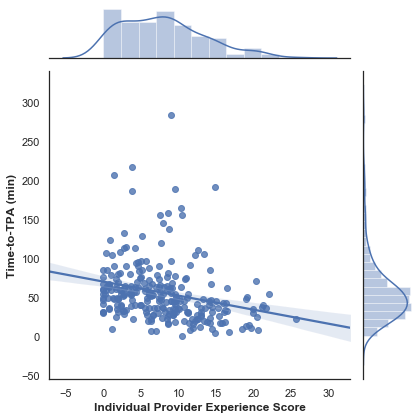

(-0.25591449149292156, 2.758264667482287e-05)


In [6]:
# plot feature user_exp_score
from sklearn.linear_model import LinearRegression as LR
from scipy.stats.stats import pearsonr 
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams.update({'font.size': 10})
plt.rcParams['axes.labelweight'] = 'bold'
import seaborn as sns
import time



X = np.load('features/user_exp_score.npy')
Time2tpa = np.load('features/t2tpa.npy')

# remove outliers
D = np.where(X<500)[0]
print(D.shape)
X = X[D]
Time2tpa = Time2tpa[D]

#plt.scatter(X,Time2tpa,color='r')

# Linear regression plot
X = np.reshape(X,(-1,1))
Time2tpa = np.reshape(Time2tpa,(-1,1))

print(X.shape)
print(Time2tpa.shape)

Time2tpa_regr = LR().fit(X, Time2tpa).predict(X)
#plt.plot(X,Time2tpa_regr, color='blue', linewidth=3)

sns.set(style="white", color_codes=True)
g = sns.jointplot(x=X, y=Time2tpa, kind="reg")


plt.xlabel('Individual Provider Experience Score')
plt.ylabel('Time-to-TPA (min)')

timestr = time.strftime("%m_%d_%Y_%H%M%S")
plt.tight_layout()
plt.savefig('figures/'+timestr +'_user_exp_score' +'.png', dpi=300)

plt.show()

print(pearsonr(np.reshape(X,(-1,)), np.reshape((Time2tpa),(-1,))))



(264, 1)
(264, 1)


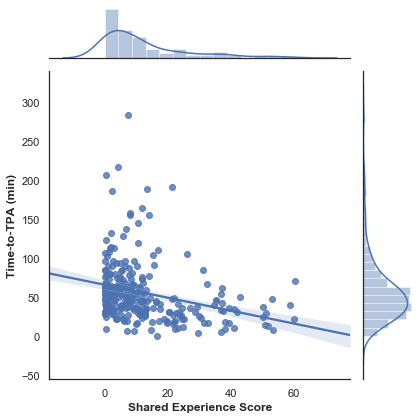

(-0.28964345830982646, 1.6944533121454647e-06)


In [7]:
# plot feature user_joint_exp_score
from sklearn.linear_model import LinearRegression as LR
rcParams['font.family'] = 'serif'
rcParams.update({'font.size': 10})
plt.rcParams['axes.labelweight'] = 'bold'
import time
import seaborn as sns



X = np.load('features/avg_user_joint_exp.npy')
Time2tpa = np.load('features/t2tpa.npy')

# remove outliers
#D = np.where((X<500) & (40<X) )[0]
#print(D.shape)
#X = X[D]
#Time2tpa = Time2tpa[D]

#plt.scatter(X,Time2tpa,color='r')

# Linear regression plot
X = np.reshape(X,(-1,1))
Time2tpa = np.reshape(Time2tpa,(-1,1))

print(X.shape)
print(Time2tpa.shape)

Time2tpa_regr = LR().fit(X, Time2tpa).predict(X)
#plt.plot(X,Time2tpa_regr, color='blue', linewidth=3)
sns.set(style="white", color_codes=True)
g = sns.jointplot(x=X, y=Time2tpa, kind="reg")


plt.xlabel('Shared Experience Score')
plt.ylabel('Time-to-TPA (min)')

timestr = time.strftime("%m_%d_%Y_%H%M%S")
plt.tight_layout()
plt.savefig('figures/'+timestr +'_avg_user_joint_exp' +'.png', dpi=300)

plt.show()

print(pearsonr(np.reshape(X,(-1,)), np.reshape((Time2tpa),(-1,))))



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


(241,)
(241, 1)
(241, 1)


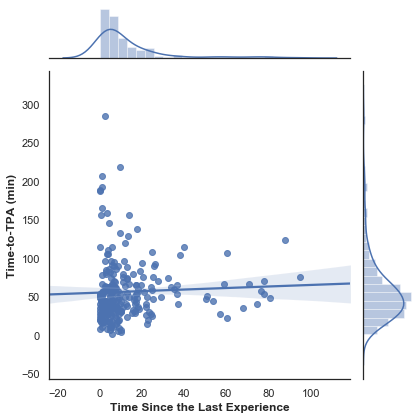

(0.043282974664112836, 0.5036533869289993)


In [8]:
## Plot Time to last TPA

from sklearn.linear_model import LinearRegression as LR

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams.update({'font.size': 10})
plt.rcParams['axes.labelweight'] = 'bold'
import time



X = np.load('features/last_tpa_score.npy')
Time2tpa = np.load('features/t2tpa.npy')

# remove outliers
D = np.where(X<100)[0]
print(D.shape)
X = X[D]
Time2tpa = Time2tpa[D]

#plt.scatter(X,Time2tpa,color='r')

# Linear regression plot
X = np.reshape(X,(-1,1))
Time2tpa = np.reshape(Time2tpa,(-1,1))

print(X.shape)
print(Time2tpa.shape)

Time2tpa_regr = LR().fit(X, Time2tpa).predict(X)
#plt.plot(X,Time2tpa_regr, color='blue', linewidth=3)

sns.set(style="white", color_codes=True)
g = sns.jointplot(x=X, y=Time2tpa, kind="reg")

plt.xlabel('Time Since the Last Experience')
plt.ylabel('Time-to-TPA (min)')

timestr = time.strftime("%m_%d_%Y_%H%M%S")
plt.tight_layout()
plt.savefig('figures/'+timestr +'_last_tpa_score' +'.png', dpi=300)

plt.show()
    
print(pearsonr(np.reshape(X,(-1,)), np.reshape((Time2tpa),(-1,))))



(241, 1)
(241, 1)


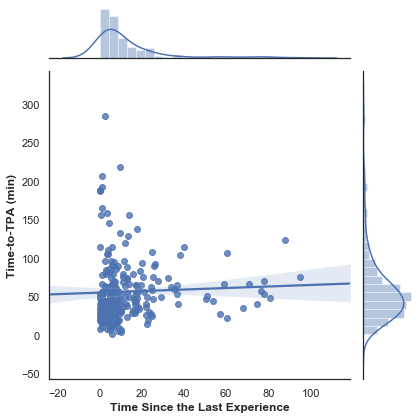

(0.043282974664112836, 0.5036533869289993)


In [9]:

print(X.shape)
print(Time2tpa.shape)

# plot
# ========================================   

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams.update({'font.size': 10})
plt.rcParams['axes.labelweight'] = 'bold'
import time





import seaborn as sns
sns.set(style="white", color_codes=True)

g = sns.jointplot(x=X, y=Time2tpa, kind="reg")
plt.xlabel('Time Since the Last Experience')
plt.ylabel('Time-to-TPA (min)')

timestr = time.strftime("%m_%d_%Y_%H%M%S")
plt.tight_layout()
plt.savefig('figures/'+timestr +'_last_tpa_score' +'.png', dpi=300)

plt.show()

print(pearsonr(np.reshape(X,(-1,)), np.reshape((Time2tpa),(-1,))))

